In [35]:
from utils.feature_utils import extract_log_features, extract_hog_features, extract_normals_features, extract_gabor_features, extract_wavelet_features, extract_bovw_features, create_visual_vocab
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from sklearn.manifold import TSNE
import os
from PIL import Image
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score


# 1. Preparing train dataset

In [2]:
# Create the images array, each row is one image
#Convert images to feature array and find labels"
def parse_img(folder_path):
    image_vectors = []  # image data\n",
    labels = []  # labels\n",

    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            parts = filename.split('_')
            fabType = parts[0]
            image = Image.open(os.path.join(folder_path, filename)).convert('L')
            img_array = np.array(image)

            # normalize the image vector to be between 0 and 1 \n",
            img_array_std = (img_array - np.mean(img_array)) / np.std(img_array)
            img_array = np.array(img_array_std)
            image_vectors.append(img_array)
            labels.append(fabType)

    X = np.array(image_vectors)
    Y = np.array(labels)
    return X, Y

## 1.1 Feature Extraction

In [3]:
folder_path = './Subsamples/train'
train_imgs, train_labels = parse_img(folder_path)

train_imgs.shape

(22128, 200, 200)

In [4]:
kmeans_fitted = create_visual_vocab(folder_path)

In [5]:
#HOG
hog_features_list = []

for image_array in train_imgs:
        hog_feature = extract_hog_features(image_array, 4, 20, scalar=False)
        hog_features_list.append(hog_feature[np.newaxis, :])
hog_features = np.vstack(hog_features_list) 
print(hog_features.shape)

(22128, 2304)


In [6]:
#BoVW features
bovw_features_list = []
for image_array in train_imgs:
    bovw_feature = extract_bovw_features(image_array, kmeans_fitted)
    bovw_features_list.append(bovw_feature)
bovw_features = np.vstack(bovw_features_list)
print(bovw_features.shape)

(22128, 20)


## 1. 2 Creation of a new dataframe with the features and labels with a downsample version

- Balance classes
- Create DF
- Save as pikle file


In [21]:
concatentated_features = np.concatenate((hog_features, bovw_features), axis=1)
df = pd.DataFrame(concatentated_features)
df['category'] = pd.Categorical(train_labels)
df['label'], _ = pd.factorize(df['category'])
df.head()

,0,1,2,3,4,5,6,7,8,9,...,2316,2317,2318,2319,2320,2321,2322,2323,category,label
0,0.081365,0.129032,0.068879,0.029360,0.081483,0.182388,0.233570,0.056316,0.097077,0.121916,...,0.018018,0.018018,0.000000,0.099099,0.036036,0.027027,0.045045,0.000000,Blended,0
1,0.232769,0.141162,0.130744,0.156622,0.161056,0.011751,0.021573,0.232769,0.232769,0.108755,...,0.119048,0.005291,0.018519,0.005291,0.095238,0.089947,0.105820,0.066138,Denim,1
2,0.100640,0.221566,0.188653,0.113977,0.184139,0.221566,0.176351,0.147671,0.147150,0.221566,...,0.053398,0.032362,0.037217,0.124595,0.027508,0.027508,0.053398,0.025890,Polyester,2
3,0.178292,0.122044,0.151578,0.135832,0.111774,0.062205,0.173567,0.221095,0.116077,0.084465,...,0.091667,0.004167,0.008333,0.016667,0.087500,0.075000,0.058333,0.058333,Blended,0
4,0.170737,0.112553,0.192354,0.185196,0.230044,0.112194,0.141223,0.150197,0.146034,0.090000,...,0.098246,0.017544,0.003509,0.049123,0.070175,0.070175,0.056140,0.028070,Cotton,3


In [22]:
#Reorder and save as a pikle in case the kernel dies
train_df = df.copy()
train_df.columns = train_df.columns.astype(str)
PIXEL_COLS = train_df.columns.tolist()[:-2] # list of pixel header
LABEL_COLS = ['label', 'category'] # list of labels header
cols_reorder = LABEL_COLS + PIXEL_COLS
train_df = train_df[cols_reorder]
train_df.head()

curr_date = '0414' # Replace dd with date 
filename = f'./pkls/vectorized_pkls/train_{curr_date}.pkl'
train_df.to_pickle(filename)

In [23]:
train_df.head()

,label,category,0,1,2,3,4,5,6,7,...,2314,2315,2316,2317,2318,2319,2320,2321,2322,2323
0,0,Blended,0.081365,0.129032,0.068879,0.029360,0.081483,0.182388,0.233570,0.056316,...,0.018018,0.000000,0.018018,0.018018,0.000000,0.099099,0.036036,0.027027,0.045045,0.000000
1,1,Denim,0.232769,0.141162,0.130744,0.156622,0.161056,0.011751,0.021573,0.232769,...,0.015873,0.047619,0.119048,0.005291,0.018519,0.005291,0.095238,0.089947,0.105820,0.066138
2,2,Polyester,0.100640,0.221566,0.188653,0.113977,0.184139,0.221566,0.176351,0.147671,...,0.016181,0.016181,0.053398,0.032362,0.037217,0.124595,0.027508,0.027508,0.053398,0.025890
3,0,Blended,0.178292,0.122044,0.151578,0.135832,0.111774,0.062205,0.173567,0.221095,...,0.016667,0.075000,0.091667,0.004167,0.008333,0.016667,0.087500,0.075000,0.058333,0.058333
4,3,Cotton,0.170737,0.112553,0.192354,0.185196,0.230044,0.112194,0.141223,0.150197,...,0.003509,0.014035,0.098246,0.017544,0.003509,0.049123,0.070175,0.070175,0.056140,0.028070


In [40]:
#balance down the dataframe

# Determine the minimum count of rows for any category
min_count = train_df['category'].value_counts().min()

# Sample dataframe with equal number of rows for each category
df_equal = train_df.groupby('category').head(min_count)

df_equal

,label,category,0,1,2,3,4,5,6,7,...,2314,2315,2316,2317,2318,2319,2320,2321,2322,2323
0,0,Blended,0.081365,0.129032,0.068879,0.029360,0.081483,0.182388,0.233570,0.056316,...,0.018018,0.000000,0.018018,0.018018,0.000000,0.099099,0.036036,0.027027,0.045045,0.000000
1,1,Denim,0.232769,0.141162,0.130744,0.156622,0.161056,0.011751,0.021573,0.232769,...,0.015873,0.047619,0.119048,0.005291,0.018519,0.005291,0.095238,0.089947,0.105820,0.066138
2,2,Polyester,0.100640,0.221566,0.188653,0.113977,0.184139,0.221566,0.176351,0.147671,...,0.016181,0.016181,0.053398,0.032362,0.037217,0.124595,0.027508,0.027508,0.053398,0.025890
3,0,Blended,0.178292,0.122044,0.151578,0.135832,0.111774,0.062205,0.173567,0.221095,...,0.016667,0.075000,0.091667,0.004167,0.008333,0.016667,0.087500,0.075000,0.058333,0.058333
4,3,Cotton,0.170737,0.112553,0.192354,0.185196,0.230044,0.112194,0.141223,0.150197,...,0.003509,0.014035,0.098246,0.017544,0.003509,0.049123,0.070175,0.070175,0.056140,0.028070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22100,4,Wool,0.083593,0.179982,0.173865,0.092292,0.184295,0.140600,0.096142,0.213820,...,0.011136,0.066815,0.089087,0.013363,0.015590,0.037862,0.057906,0.062361,0.073497,0.040089
22104,4,Wool,0.066007,0.157533,0.233793,0.071045,0.079224,0.080031,0.224135,0.175280,...,0.022727,0.056818,0.113636,0.034091,0.003788,0.037879,0.053030,0.045455,0.049242,0.060606
22109,4,Wool,0.121716,0.166307,0.201407,0.064358,0.111571,0.215154,0.204361,0.114560,...,0.004454,0.053452,0.095768,0.022272,0.015590,0.091314,0.022272,0.028953,0.042316,0.008909
22114,4,Wool,0.226777,0.180492,0.145221,0.115153,0.133729,0.130393,0.159472,0.059000,...,0.006944,0.034722,0.111111,0.013889,0.024306,0.010417,0.065972,0.052083,0.072917,0.024306


# 2. Preparing the Test Dataset
### 2.1 Feature extraction

In [26]:
folder_path = './Subsamples/test'
test_imgs, test_labels = parse_img(folder_path)

test_imgs.shape

(4729, 200, 200)

In [27]:
#HOG
hog_features_list = []

for image_array in test_imgs:
        hog_feature = extract_hog_features(image_array, 4, 20, scalar=False)
        hog_features_list.append(hog_feature[np.newaxis, :])
hog_features_test = np.vstack(hog_features_list) 
print(hog_features_test.shape)

(4729, 2304)


In [28]:
#BOVW 
kmeans_fitted = create_visual_vocab(folder_path)

#BoVW features
bovw_features_list = []
for image_array in test_imgs:
    bovw_feature = extract_bovw_features(image_array, kmeans_fitted)
    bovw_features_list.append(bovw_feature)
bovw_features_test = np.vstack(bovw_features_list)
print(bovw_features_test.shape)

(4729, 20)


### 2.2 Saving as a pikle dataframe

In [30]:
concatentated_features = np.concatenate((hog_features_test, bovw_features_test), axis=1)
df = pd.DataFrame(concatentated_features)
df['category'] = pd.Categorical(test_labels)
label_map =  {'Polyester': 2, 'Blended': 0, 'Cotton': 3, 'Denim': 1  , 'Wool': 4}
df['label'] = df['category'].map(label_map)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,2316,2317,2318,2319,2320,2321,2322,2323,category,label
0,0.223220,0.089830,0.163692,0.179004,0.223220,0.120967,0.146618,0.197932,0.175036,0.045305,...,0.132275,0.026455,0.005291,0.000000,0.000000,0.000000,0.089947,0.000000,Polyester,2
1,0.102044,0.188833,0.201389,0.134063,0.179883,0.189905,0.121700,0.184097,0.159279,0.207076,...,0.058728,0.047308,0.008157,0.011419,0.004894,0.021207,0.075041,0.047308,Cotton,3
2,0.086880,0.050499,0.141917,0.077395,0.039838,0.060292,0.136925,0.021899,0.238946,0.194106,...,0.066667,0.040000,0.040000,0.013333,0.000000,0.000000,0.080000,0.000000,Blended,0
3,0.136648,0.158364,0.097818,0.060058,0.257023,0.086337,0.057119,0.165126,0.257023,0.127133,...,0.150877,0.021053,0.035088,0.024561,0.000000,0.007018,0.049123,0.014035,Cotton,3
4,0.211817,0.203020,0.211817,0.173540,0.211817,0.086403,0.157048,0.153992,0.205830,0.097961,...,0.110787,0.043732,0.011662,0.014577,0.000000,0.000000,0.061224,0.014577,Cotton,3


In [31]:
#Save as pkl
#Reorder and save as a pikle in case the kernel dies
test_df = df.copy()
test_df.columns = test_df.columns.astype(str)
PIXEL_COLS = test_df.columns.tolist()[:-2] # list of pixel header
LABEL_COLS = ['label', 'category'] # list of labels header
cols_reorder = LABEL_COLS + PIXEL_COLS
test_df = test_df[cols_reorder]


curr_date = '0414' # Replace dd with date 
filename = f'./pkls/vectorized_pkls/test_{curr_date}.pkl'
test_df.to_pickle(filename)
test_df.head()

,label,category,0,1,2,3,4,5,6,7,...,2314,2315,2316,2317,2318,2319,2320,2321,2322,2323
0,2,Polyester,0.223220,0.089830,0.163692,0.179004,0.223220,0.120967,0.146618,0.197932,...,0.084656,0.026455,0.132275,0.026455,0.005291,0.000000,0.000000,0.000000,0.089947,0.000000
1,3,Cotton,0.102044,0.188833,0.201389,0.134063,0.179883,0.189905,0.121700,0.184097,...,0.024470,0.034258,0.058728,0.047308,0.008157,0.011419,0.004894,0.021207,0.075041,0.047308
2,0,Blended,0.086880,0.050499,0.141917,0.077395,0.039838,0.060292,0.136925,0.021899,...,0.026667,0.040000,0.066667,0.040000,0.040000,0.013333,0.000000,0.000000,0.080000,0.000000
3,3,Cotton,0.136648,0.158364,0.097818,0.060058,0.257023,0.086337,0.057119,0.165126,...,0.091228,0.024561,0.150877,0.021053,0.035088,0.024561,0.000000,0.007018,0.049123,0.014035
4,3,Cotton,0.211817,0.203020,0.211817,0.173540,0.211817,0.086403,0.157048,0.153992,...,0.055394,0.034985,0.110787,0.043732,0.011662,0.014577,0.000000,0.000000,0.061224,0.014577


# 3. Run SVM model


In [32]:
def svm_grid_search_cv(X, y, cv_folds=5):
    """
    Perform grid search cross-validation for SVM classifier on the given dataframe.
    
    Parameters:
    # - dataframe: The pandas DataFrame containing the dataset.
    # - features: List of column names to be used as features.
    - target: The name of the column to be used as the target variable.
    - cv_folds: Number of folds for cross-validation.
    
    Returns:
    - grid_search: The fitted GridSearchCV object.
    """
    
    # # Separate the features and the target variable
    # X = dataframe[features]
    # y = dataframe[target]
    
    # Split the data into training and testing sets (optional, could also perform CV on the entire dataset)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)
    
    # Define a pipeline that includes scaling and the classifier
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Feature scaling is important for SVM
        ('svm', SVC(probability=True))  # SVM classifier
    ])
    
    # Parameter grid for GridSearchCV
    param_grid = {
        'svm__C': [0.1, 1, 10],  # SVM regularization parameter
        'svm__kernel': ['linear', 'rbf'],  # Kernel type to be used in the algorithm
        'svm__gamma': ['scale', 'auto']  # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
    }
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv_folds, scoring='accuracy', verbose=3, n_jobs=-1)
    
    # Perform grid search cross-validation
    grid_search.fit(X_train, y_train)
    
    print("Best parameters found: ", grid_search.best_params_)
    print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
    
    # Optionally, evaluate on the test set
    test_score = grid_search.score(X_test, y_test)
    print("Test set score: {:.2f}".format(test_score))
    
    return grid_search

In [42]:
#Train the model
X_train = df_equal.iloc[:,2:] 
y_train = df_equal.iloc[:,0] #numerical labels

cv_params = svm_grid_search_cv(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END svm__C=0.1, svm__gamma=scale, svm__kernel=linear;, score=0.432 total time=15.7min
[CV 5/5] END svm__C=0.1, svm__gamma=scale, svm__kernel=linear;, score=0.435 total time=15.8min
[CV 2/5] END svm__C=0.1, svm__gamma=scale, svm__kernel=linear;, score=0.448 total time=15.9min
[CV 3/5] END svm__C=0.1, svm__gamma=scale, svm__kernel=linear;, score=0.444 total time=15.9min
[CV 4/5] END svm__C=0.1, svm__gamma=scale, svm__kernel=linear;, score=0.453 total time=16.0min
[CV 5/5] END svm__C=0.1, svm__gamma=scale, svm__kernel=rbf;, score=0.320 total time=19.4min
[CV 1/5] END svm__C=0.1, svm__gamma=scale, svm__kernel=rbf;, score=0.340 total time=19.4min
[CV 4/5] END svm__C=0.1, svm__gamma=scale, svm__kernel=rbf;, score=0.329 total time=19.5min
[CV 2/5] END svm__C=0.1, svm__gamma=scale, svm__kernel=rbf;, score=0.343 total time=19.5min
[CV 3/5] END svm__C=0.1, svm__gamma=scale, svm__kernel=rbf;, score=0.339 total time=19.5min
[CV 

In [49]:
y_pred = cv_params.best_estimator_.predict(X_train)

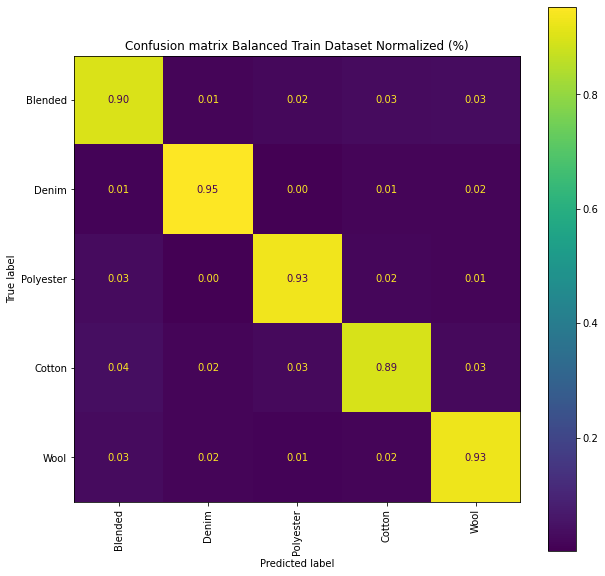

In [50]:

# Compute confusion matrix
cm = confusion_matrix(y_train, y_pred)

class_names = ['Blended', 'Denim', 'Polyester', 'Cotton', 'Wool']

# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size as necessary
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)

# To improve readability, you might not want to display labels for all classes if there are many of them
disp.plot(include_values=True, cmap='viridis', ax=ax, xticks_rotation='vertical', values_format='.2f')
# disp.plot(cmap='viridis', ax=ax, xticks_rotation='vertical')
plt.title('Confusion matrix Balanced Train Dataset Normalized (%)')

plt.show()

In [45]:
#Apply it to test

X_test = test_df.iloc[:,2:] 
y_test = test_df.iloc[:,0] #numerical labels

y_pred = cv_params.best_estimator_.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy test set: ", accuracy)

Accuracy test set:  0.3806301543666737


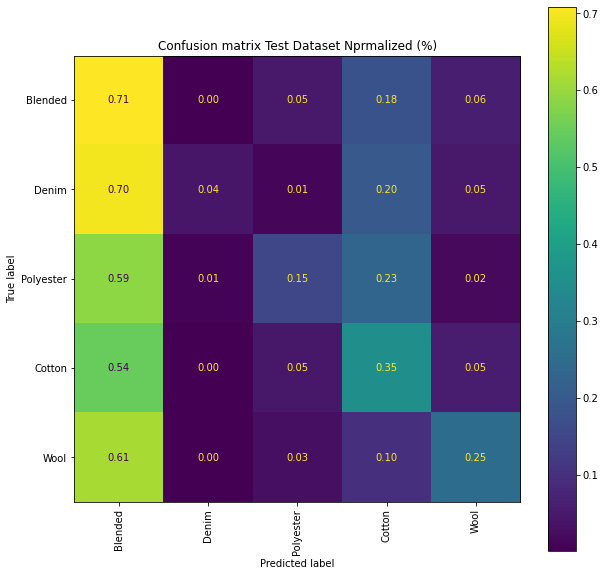

In [47]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate sum of each row
row_sums = cm.sum(axis=1, keepdims=True)

# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

class_names = ['Blended', 'Denim', 'Polyester', 'Cotton', 'Wool']

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size as necessary
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)

# To improve readability, you might not want to display labels for all classes if there are many of them
disp.plot(include_values=True, cmap='viridis', ax=ax, xticks_rotation='vertical', values_format='.2f')
# disp.plot(cmap='viridis', ax=ax, xticks_rotation='vertical')
plt.title('Confusion matrix Test Dataset Nprmalized (%)')
plt.show()